In [32]:
from reconstruct import * 
from projection_import import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import imageio
from scipy.ndimage import median_filter, uniform_filter
import re

In [33]:
# Specify the path to the HDF5 file
#file_path = r"C:\Users\gdhakal\Documents\Git\Automatic_COR_finder\C200\5_230110_1358_C200_____Z90_Y6460_50000eV_2x_300ms\5_230110_1358_00001.h5"

# Specify the folder to save and load the TIFF files
tiff_folder = r"C:\Users\gdhakal\Documents\Git\Automatic_COR_finder\Experiment Notebooks\Tiffs\C200_2\intensities\32None"

# Folder containing the TIFF images
crop_folder = r"C:\Users\gdhakal\Documents\Git\Automatic_COR_finder\Experiment Notebooks\Tiffs\C200_2\intensities\32None\cropped"

# Create an instance of ProjectionFile
#FileObject = ProjectionFile(file_path)

# Open the HDF5 file and retrieve the volume and metadata
volume_path = "/entry/data/data"
metadata_paths = ['/entry/instrument/NDAttributes/CT_MICOS_W']

volume, metadata = FileObject.openFile(volume=volume_path, metadata=metadata_paths)

volume opened successfully : data shape:  (1871, 2160, 2560)


In [34]:
# Function to divide a single image into a 4x4 matrix
def divide_image(image_path):
    # Load the TIFF image
    image = Image.open(image_path)

    # Get the dimensions of the image
    width, height = image.size

    # Define the size of the smaller images
    tile_width = width // 4
    tile_height = height // 4

    # Initialize an empty list to store the smaller images
    tiles = []

    # Divide the image into a 4x4 matrix of smaller images
    for y in range(4):
        for x in range(4):
            # Define the coordinates of the current tile
            left = x * tile_width
            upper = y * tile_height
            right = left + tile_width
            lower = upper + tile_height

            # Crop the tile from the original image
            tile = image.crop((left, upper, right, lower))

            # Append the tile to the list
            tiles.append(tile)

    return tiles

# List all TIFF files in the folder
tiff_files = [file for file in os.listdir(tiff_folder) if file.endswith(".tif")]

# Loop through each TIFF file and divide into 4x4 matrices
for tiff_file in tiff_files:
    image_path = os.path.join(tiff_folder, tiff_file)
    tiles = divide_image(image_path)

    # Remove the ".tif" extension from the tiff_file name
    tiff_file_name = os.path.splitext(tiff_file)[0]

    # Save each smaller image
    for i, tile in enumerate(tiles):
        tile.save(os.path.join(crop_folder, f"{tiff_file_name}_t{i}.tif"))

In [35]:

def por_calculate_std_dev(image_path):
    image = Image.open(str(image_path))
    imarray = np.array(image)
    std_dev = np.std(imarray)
    return std_dev

#Function to read and give COR, e and n of a file
def crop_parse_reconstructed_filename(filename):
    # Extract COR, e, and n values from the filename using regular expressions
    match = re.search(r"reconstructed_cor_(\d+p\d+)_t(\d+)\.tif", filename)
    
    if match:
        cor = float(match.group(1).replace("p", "."))
        t1 = int(match.group(2))
        
        return cor, t1
    
    return None

# Initialize arrays to store COR, e, and n values
cor_file = []
path  = []
fname = []
t_file = []
std_file = []
# Iterate over the TIFF files in the directory
for filename in os.listdir(crop_folder):
    if filename.endswith(".tif"):
        # Get the full file path
        filepath = os.path.join(crop_folder, filename)
        
        # Parse the COR, e, and n values from the filename
        cor, t1 = crop_parse_reconstructed_filename(filename)
        std = por_calculate_std_dev(filepath) 
        # Append the values to the respective arrays
        cor_file.append(cor)
        path.append(filepath)
        fname.append(filename)
        t_file.append(t1)
        std_file.append(std)


df_crop = pd.DataFrame({"path": path , "filename":fname,"COR":  cor_file , "t": t_file, "std": std_file})

df_crop

,path,filename,COR,t,std
0,C:\Users\gdhakal\Documents\Git\Automatic_COR_f...,reconstructed_cor_1073p9_t0.tif,1073.9,0,1.838009
1,C:\Users\gdhakal\Documents\Git\Automatic_COR_f...,reconstructed_cor_1073p9_t1.tif,1073.9,1,2.725521
2,C:\Users\gdhakal\Documents\Git\Automatic_COR_f...,reconstructed_cor_1073p9_t10.tif,1073.9,10,15.663792
3,C:\Users\gdhakal\Documents\Git\Automatic_COR_f...,reconstructed_cor_1073p9_t11.tif,1073.9,11,2.997627
4,C:\Users\gdhakal\Documents\Git\Automatic_COR_f...,reconstructed_cor_1073p9_t12.tif,1073.9,12,1.975222
...,...,...,...,...,...
1547,C:\Users\gdhakal\Documents\Git\Automatic_COR_f...,reconstructed_cor_1500p0_t5.tif,1500.0,5,10.286222
1548,C:\Users\gdhakal\Documents\Git\Automatic_COR_f...,reconstructed_cor_1500p0_t6.tif,1500.0,6,14.775917
1549,C:\Users\gdhakal\Documents\Git\Automatic_COR_f...,reconstructed_cor_1500p0_t7.tif,1500.0,7,7.276021
1550,C:\Users\gdhakal\Documents\Git\Automatic_COR_f...,reconstructed_cor_1500p0_t8.tif,1500.0,8,11.540619


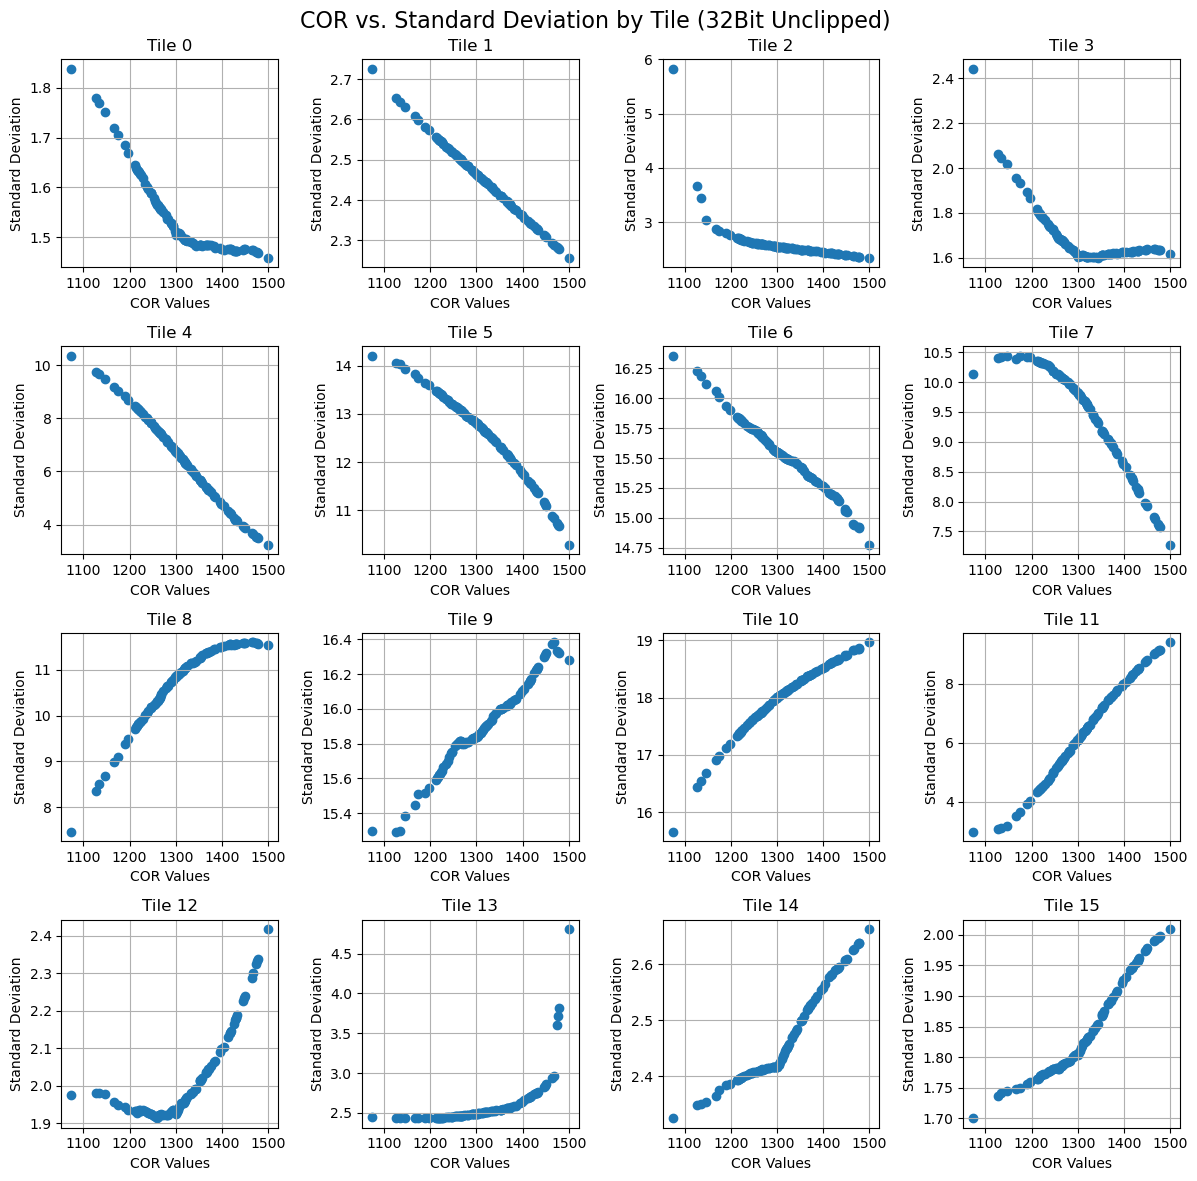

In [36]:
# Create subplots for each tile
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Plot the correlation between 'COR' and 'std' for each 't' value
for tile_number in range(16):
    data_subset = df_crop[df_crop['t'] == tile_number]
    ax = axes[tile_number // 4, tile_number % 4]  # Get the specific subplot
    ax.scatter(data_subset['COR'], data_subset['std'])
    ax.set_title(f"Tile {tile_number}")
    ax.set_xlabel('COR Values')
    ax.set_ylabel('Standard Deviation')
    ax.grid(True)

# Add a title for the entire figure
fig.suptitle("COR vs. Standard Deviation by Tile (32Bit Unclipped)", fontsize=16)

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the plots
plt.show()

In [37]:
# # Filter data for t4
# df_t = df_crop[df_crop['t'] == 4]

# # Create scatter plot for t4
# plt.scatter(df_t['COR'], df_t['std'])
# plt.xlabel('COR Values')
# plt.ylabel('Standard Deviation')
# plt.title('COR vs. Standard Deviation')
# plt.grid(True)
# plt.show()